In [12]:
%pylab inline
import os, csv
import operator

Populating the interactive namespace from numpy and matplotlib


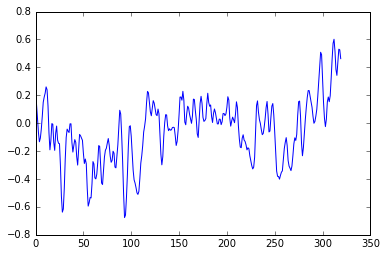

In [13]:
data_to_charge = 0 # 0 is for the music samples, 1 is for TIMIT
if data_to_charge not in (0, 1):
    raise ValueError("data_to_charge must be 0 (music) or 1 (speech)")
elif data_to_charge == 0:
    data_folder = "../sample/"
else:
    data_folder = "../timit"

files_names = (os.listdir(data_folder))
folder_size = len(files_names)
sample_lenght = 0

cr = csv.reader(open(data_folder + files_names[0], "r"))
for row in cr:
    sample_lenght += 1

data = np.zeros((folder_size, sample_lenght, 2))
    
for file_number, file in enumerate(files_names):
    cr = csv.reader(open(data_folder + file, "r"))
    for row_number, row in enumerate(cr):
        data[file_number][row_number] = [float(row[0]), float(row[1])]
        
plot(data[4][:,0])

In [98]:
class CWRNNNumpy:
    
    def __init__(self, out_dim, nb_group, nb_member, bptt_truncate=4):
        # Assign instance variables
        self.out_dim = out_dim
        self.nb_group = nb_group
        self.nb_member = nb_member
        self.hidden_dim = nb_group*nb_member
        self.bptt_truncate = bptt_truncate
        # Randomly initialize the network parameters
        self.V = np.random.normal(0, 0.1, (out_dim, self.hidden_dim))
        self.W = np.zeros((self.hidden_dim, self.hidden_dim))
        for i in range(nb_group) :
            for j in range(nb_member):
                self.W[i*nb_member+j][i:] = np.random.normal(0, 0.1, (self.hidden_dim-i))
        self.bW = np.random.normal(0, 0.1, (self.hidden_dim))
        self.bV = np.random.normal(0, 0.1, (out_dim))



In [150]:
def which_active(self, t):
    active = self.nb_group
    while(True):
        t = t% 2**(active - 1)
        if(t == 0): break;
        active-=1
    return active
CWRNNNumpy.which_active=which_active


def forward_propagation(self, size, initialState):
    # The total number of time steps
    T = size
    # During forward propagation we save all hidden states in s because need them later.
    s = np.zeros((T , self.hidden_dim))
    s[-1] = np.ones( self.hidden_dim)*initialState
    # The outputs at each time step. Again, we save them for later.
    o = np.zeros((T, self.out_dim))
    # For each time step...
    for t in np.arange(T):
        #active : last group active for time t
        active = self.which_active(t)
        s[t][:active*self.nb_member] = np.tanh(self.W[:active*self.nb_member].dot(s[t-1]) 
                                               + self.bW[:active*self.nb_member])
        s[t][active*self.nb_member:] = s[t-1][active*self.nb_member:]
        o[t] = self.V.dot(s[t]) + self.bV
    return [o, s]

CWRNNNumpy.forward_propagation = forward_propagation

In [151]:
def predict(self, x):
    # Perform forward propagation and return index of the highest score
    o, s = self.forward_propagation(len(x), x[0])
    return o

CWRNNNumpy.predict = predict

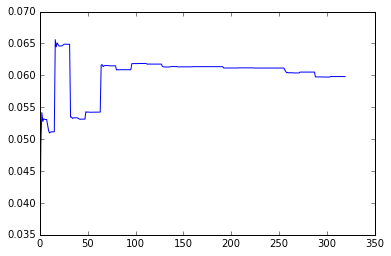

In [171]:
model = CWRNNNumpy(out_dim=1, nb_group=10, nb_member=1)
X_train = data[4][:,0]
#X_train = np.ones(320)
o = model.predict(X_train)
plot(o)

In [162]:
model.W

array([[ 0.08637808,  0.00197847,  0.0655152 , -0.17234318, -0.0481428 ,
         0.07913605,  0.01446624,  0.17944357,  0.09434522,  0.15725331],
       [ 0.        , -0.0571188 ,  0.02718668,  0.03135085,  0.03364756,
         0.07002415,  0.24308995,  0.12401152, -0.00472568,  0.15821838],
       [ 0.        ,  0.        ,  0.08301255, -0.06758341, -0.03304455,
        -0.08279678, -0.06698862, -0.10949025, -0.02367053, -0.22502029],
       [ 0.        ,  0.        ,  0.        , -0.02816689,  0.14821467,
        -0.13693039, -0.0350257 , -0.02744819,  0.00490491,  0.10590761],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.13778171,
         0.03338539,  0.07100426,  0.01147312, -0.01417685, -0.10583592],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.03446994, -0.16932544,  0.06255677, -0.24152952, -0.05609177],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.01150358, -0.00076893

In [163]:
def calculate_loss(self, x):
    o, s = self.forward_propagation(len(x), x[1])
    o=o.reshape(x.shape)
    return ((x-o)*(x-o)).sum()
CWRNNNumpy.calculate_loss=calculate_loss

In [164]:
loss = model.calculate_loss( X_train)
loss

329.21019025301479

In [165]:
def bptt(self, y):
    T = len(y)
    # Perform forward propagation
    o, s = self.forward_propagation(len(y), y[0])
    # We accumulate the gradients in these variables
    dLdV = np.zeros(self.V.shape)
    dLdW = np.zeros(self.W.shape)
    dLdbW = np.zeros(self.bW.shape)
    dLdbV = np.zeros(self.bV.shape)
    delta_o = (y.reshape((T,1)) - o)

    # For each output backwards...
    for t in np.arange(T)[::-1]:
        active=self.which_active(T-1)
        dLdV += delta_o[t] * (s[t])
        dLdbV += delta_o[t]
        # Initial delta calculation
        delta_t = self.V.T.dot(delta_o[t])
        for bptt_step in np.arange(max(0, t-self.bptt_truncate), t+1)[::-1]:
            active=self.which_active(bptt_step)
            # print "Backpropagation step t=%d bptt step=%d " % (t, bptt_step)
            if(bptt_step>0):
                dLdW += np.outer(delta_t, np.hstack((s[bptt_step-1][:active*self.nb_member], np.zeros((
                                self.hidden_dim-active*self.nb_member)))))  
                dLdbW += np.hstack((delta_t[:active*self.nb_member], 
                                    np.zeros((self.hidden_dim-active*self.nb_member))))
            # Update delta for next step
            
            if(active != self.nb_group):
                Wtmp = np.vstack((self.W[:active*self.nb_member],
                                  np.zeros((self.hidden_dim-(active*self.nb_member),
                                            self.hidden_dim))))
            else : Wtmp = self.W   
            delta_t = Wtmp.T.dot(delta_t) * (1 - s[bptt_step-1] ** 2)
    return [dLdV, dLdbV, dLdW, dLdbW]

CWRNNNumpy.bptt = bptt

In [166]:
# Performs one step of SGD.
def numpy_sdg_step(self, x, learning_rate):
    # Calculate the gradients
    dLdV, dLdbV, dLdW, dLdbW = self.bptt(x)
    # Change parameters according to gradients and learning rate
    self.V += learning_rate * dLdV
    self.W += learning_rate * dLdW
    self.bV += learning_rate * dLdbV
    self.bW += learning_rate * dLdbW
CWRNNNumpy.sgd_step = numpy_sdg_step

In [167]:
# Outer SGD Loop
# - model: The RNN model instance
# - x: séquence to generate
# - learning_rate: Initial learning rate for SGD
# - nepoch: Number of times to iterate through the complete dataset
def train_with_sgd(model, x, learning_rate=0.0003, nepoch=100):
    # We keep track of the losses so we can plot them later
    losses = []
    for epoch in range(nepoch):
        # One SGD step
        loss = model.calculate_loss(x)
        losses.append(loss)
        model.sgd_step(x, learning_rate)
        
    return losses
 

In [178]:

losses = train_with_sgd(model, X_train, nepoch=900, learning_rate=0.01)

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in multiply


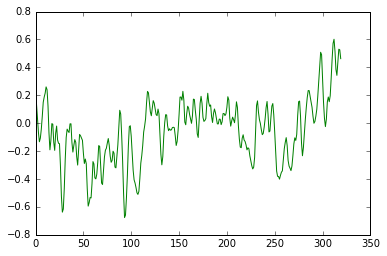

In [179]:

o = model.predict(X_train)
plot(o)
plot(X_train)

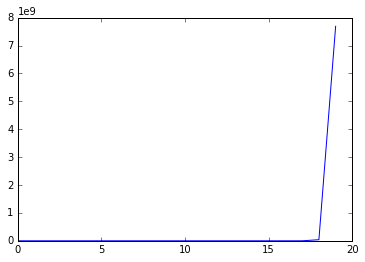

In [185]:
plot(losses[:20])

In [181]:
model.W

array([[ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan]])

3.9467341180984985e+138